# Grama: A Gammar of Model Analysis 

*Author*: Zachary del Rosario (zdelrosario@olin.edu)

---

Grama[1] is a software implementation of a *grammar of model analysis*: A software package to facilitate analyzing physical models with quantified uncertainties. Its design is intended to support *teaching physical modeling* and *clarifying scientific reporting*.

## Application: Building Capacity by Teaching Principled Validation

In this document, I demonstrate how Grama can be used to both *carry out* and *teach* principled validation of physical models. I demonstrate how Grama can be used to calibrate a physical model with example trajectory data, and illustrate the kind of validation exercise an analyst should use to "stress test" a model. These ideas are simple to implement and read in Grama, owing to its user-first syntax.

This is a reproducible example: An executable piece of code that can be downloaded and re-run locally.

In [7]:
## Package setup
import grama as gr
import plotnine as gg
import pandas as pd

X = gr.Intention()

## Modeling Trajectory Data

In this example we will study two sources of projectile trajectory data. The following code loads and visualizes the data.


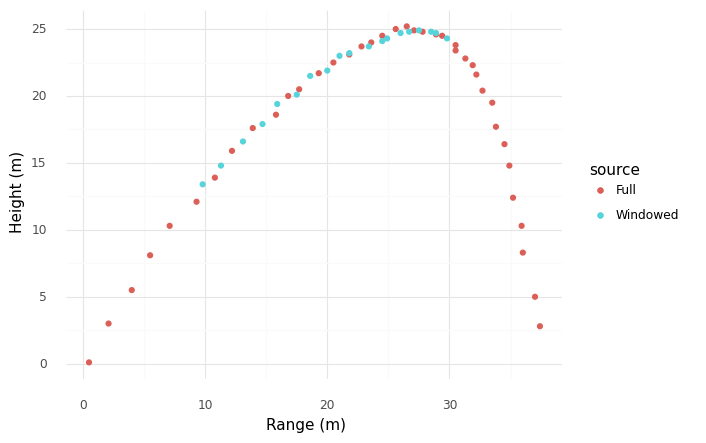

<ggplot: (8762481366213)>

In [2]:
## Load example datasets
from grama.data import df_trajectory_full
from grama.data import df_trajectory_windowed

## Visualize the data
(
    gg.ggplot(mapping=gg.aes("x", "y"))
    + gg.geom_point(
        data=df_trajectory_full >> gr.tf_mutate(source="Full"), 
        mapping=gg.aes(color="source")
    )
    + gg.geom_point(
        data=df_trajectory_windowed >> gr.tf_mutate(source="Windowed"), 
        mapping=gg.aes(color="source")
    )
    + gg.theme_minimal()
    + gg.labs(
        x="Range (m)",
        y="Height (m)",
    )
)

There are two data sources: a **Windowed** dataset with restricted measurements, and a **Full** dataset that follows the projectile from launch to landing.

Next, we load a pre-built Grama model:

In [3]:
## Load a pre-built model
from grama.models import make_trajectory_linear
md_trajectory = make_trajectory_linear()
md_trajectory.printpretty()

model: Trajectory Model

  inputs:
    var_det:
      tau: [0.05, inf]
      v0: [0.1, inf]
      t: (unbounded)
      u0: [0.1, inf]
    var_rand:
    copula:
        None
  functions:
    x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
    y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']


The `printpretty()` function summarizes the model in terms of its `inputs`, its characterization of uncertainty (through random variables `var_rand` and dependency structure `copula`), and its `functions` that map inputs to outputs. The source code for this model is available [at this link](https://github.com/zdelrosario/py_grama/blob/master/grama/models/trajectory_linear_drag.py); Grama allows one to decompose modeling into *model building* and *model analysis*. For this exercise we assume the model has already been built and that we are only seeking to validate it with data.

The model has unknown parameters; namely the projectile's initial velocity `u0, v0` and drag time constant `tau`. We fit these parameters from the Windowed data via nonlinear least squares [(NLS)](https://en.wikipedia.org/wiki/Non-linear_least_squares) with the Grama routine `fit_nls()`.

In [4]:
## Fit the model based on Windowed data
md_fit = gr.fit_nls(
    df_trajectory_windowed,
    md=md_trajectory,
    maxiter=100
)
md_fit.printpretty()

... eval_nls setting out = ['x', 'y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
        tau         v0         u0  tau_0  v0_0  u0_0  status       mse
0  2.796048  28.239054  18.809541   0.05   0.1   0.1       0  0.093446
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)
    var_rand:
    copula:
        None
  functions:
    Fix variable levels: ['t'] -> ['tau', 'v0', 'u0']
    Trajectory Model: ['tau', 'v0', 't', 'u0'] -> ['x', 'y']


Note that the Grama routine `fit_nls()` automatically infers which quantities in `df_windowed` are outputs and inputs based on the information provided in the physical trajectory model `md_trajectory`. Furthermore, the routine recognizes that the variable `t` should not be fit as it is provided in the data `df_windowed`. The output of `fit_nls()` is a new model with fixed values for `u0, v0, tau`. We can now simulate the trajectory at the same time points `t` in the windowed dataset to assess the model's accuracy.

The Grama routine `eval_df` evaluates a given model using a `DataFrame` of desired values; in our case `df_trajectory_windowed` contains time points `t` we wish to simulate.


... provided columns intersect model output.
eval_df() is dropping {'x', 'y'}


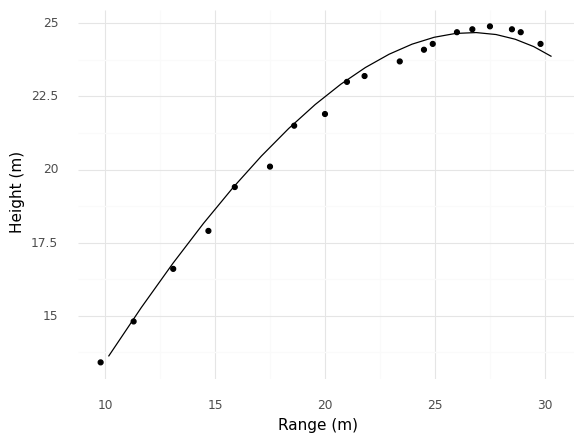

<ggplot: (8762464645161)>

In [5]:
## Evaluate the fitted model
df_fit = gr.eval_df(md_fit, df=df_trajectory_windowed)

## Compare fit against data
(
    gg.ggplot(mapping=gg.aes("x", "y"))
    + gg.geom_line(data=df_fit)
    + gg.geom_point(data=df_trajectory_windowed)
    + gg.theme_minimal()
    + gg.labs(
        x="Range (m)",
        y="Height (m)",
    )
)

Note that the agreement between the model and the data is visually quite good. However, this is a novice mistake: One should use *validation data* not used to calibrate the model in order to assess the model accuracy.


## Validation data

Since we fit the model on `df_trajectory_windowed`, we can use `df_trajectory_full` as *validation data* to better assess the model. Note that the full dataset contains trajectory points outside the windowed set: Testing the model on the full dataset will assess whether the model can successfully *extrapolate*.


... provided columns intersect model output.
eval_df() is dropping {'x', 'y'}


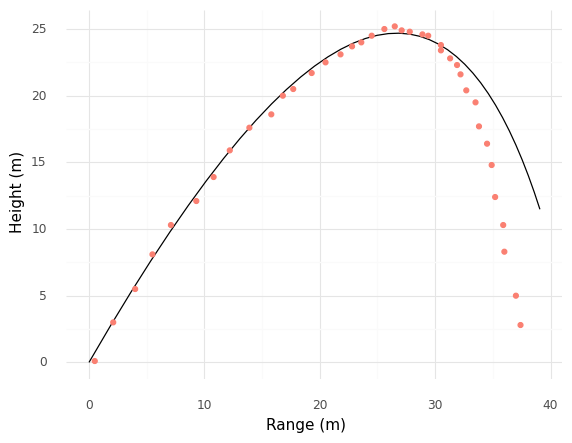

<ggplot: (8762464614513)>

In [6]:
## Evaluate the fitted model on validation data
df_fit_full = gr.eval_df(md_fit, df=df_trajectory_full)

## Compare fit against full data
(
    gg.ggplot(mapping=gg.aes("x", "y"))
    + gg.geom_line(data=df_fit_full)
    + gg.geom_point(data=df_trajectory_full, color="salmon")
    + gg.theme_minimal()
    + gg.labs(
        x="Range (m)",
        y="Height (m)",
    )
)

This assessment exercise indicates that the model *cannot* successfully extrapolate, refuting the conclusion we drew above. The next step for the analyst would be to revisit the [model definition](https://github.com/zdelrosario/py_grama/blob/master/grama/models/trajectory_linear_drag.py) to determine what physical assumptions are invalid in this experimental setting.


# References

- [1] del Rosario, Z., (2020). Grama: A Grammar of Model Analysis. Journal of Open Source Software, 5(51), 2462, https://doi.org/10.21105/joss.02462